In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
data = np.genfromtxt("expressions.txt")
data = data[:,1:]

types = []
mapSampleToType = {}

with open("tcga-pancan-hiseqlabels.csv", 'r') as file:
    file.readline() 
    for line in file: 
        sample, Type = line.strip().split(',',1)
        mapSampleToType[sample] = Type

with open("expressions.txt", 'r') as file:
    for line in file:
        sample, aux = line.split(" ", 1)
        types.append(mapSampleToType[sample])

for i in range (len(types)):
    if types[i] == "PRAD":
        types[i] = 0
    elif types[i] == "LUAD": 
        types[i] = 1
    elif types[i] == "BRCA":
        types[i] = 2
    elif types[i] == "KIRC":
        types[i] = 3
    elif types[i] == "COAD":
        types[i] = 4

types = np.array(types, dtype=int) 
pca = PCA(n_components=2) 
data_2d = pca.fit_transform(data)

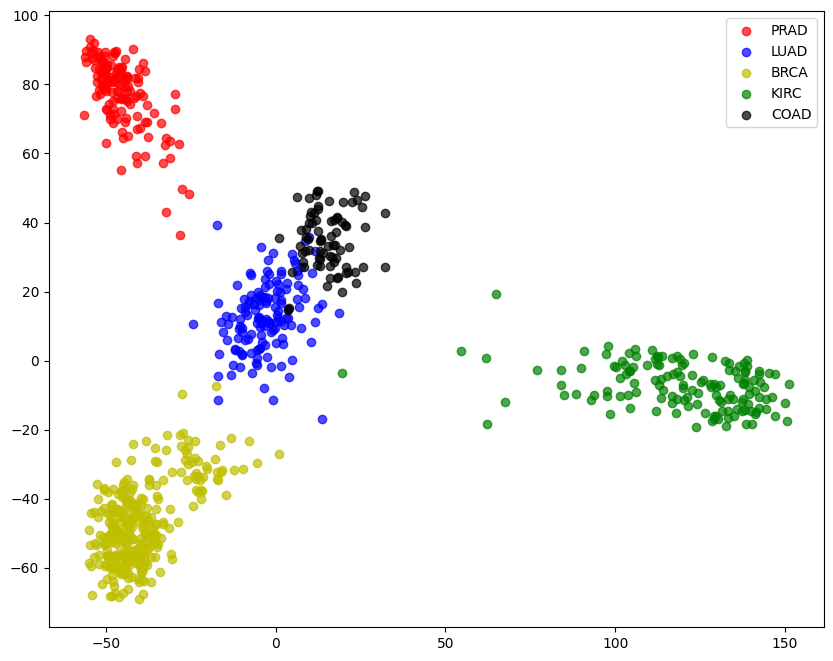

In [3]:
colors = ['r', 'b', 'y', 'g', 'k'] 

plt.figure(figsize=(10, 8)) 
for i, tumor_name in enumerate(["PRAD", "LUAD", "BRCA", "KIRC", "COAD"]): 
    data_single_type = data_2d[types == i]
    plt.scatter(data_single_type[:,0], data_single_type[:,1], color=colors[i], label=tumor_name, alpha=0.7)
plt.legend()
plt.show()

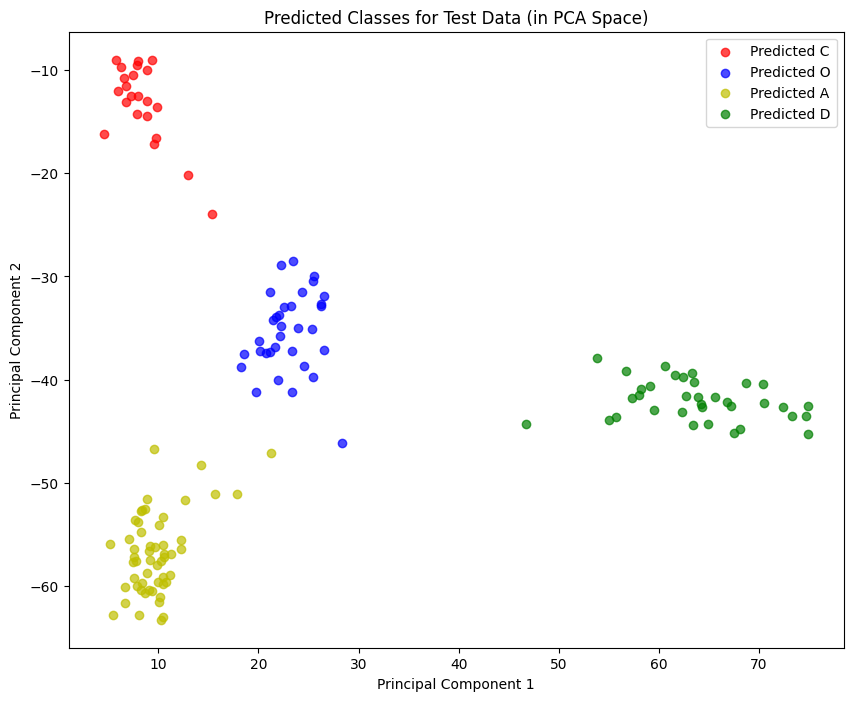

The accuracy of the prediction is  100.0 %


In [4]:
dataTrain, dataTest, typeTrain, typeTest = train_test_split(data, types, test_size = 0.20)
stdScalar = StandardScaler()
stdScalar.fit(dataTrain)
dataTrain = stdScalar.transform(dataTrain)
dataTest = stdScalar.transform(dataTest)
perceptron = Perceptron(max_iter = 50, tol = 0.001, random_state=42)
perceptron.fit(dataTrain, typeTrain)
typesPredicted = perceptron.predict(dataTest)
testData_2d = pca.transform(dataTest)

plt.figure(figsize=(10, 8))

for i in range(len(tumor_name)):
    data_single_predicted_type = testData_2d[typesPredicted == i]
    if data_single_predicted_type.shape[0] > 0:
        plt.scatter(data_single_predicted_type[:, 0],
                    data_single_predicted_type[:, 1],
                    color=colors[i],                 
                    label=f"Predicted {tumor_name[i]}", 
                    alpha=0.7)                  

plt.title("Predicted Classes for Test Data (in PCA Space)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend() 
plt.show()

print("The accuracy of the prediction is " ,accuracy_score(typeTest, typesPredicted)*100, "%")


In [5]:
original_weights = perceptron.coef_ 

max_weight_gene_indices = np.argmax(original_weights, axis=1)

print("\n--- Single Gene Classifier Accuracies ---")
for t in range(5):
    gene_index_for_rule = max_weight_gene_indices[t]
    typeSingleTrain_binary = np.zeros_like(typeTrain, dtype=int)
    typeSingleTrain_binary[typeTrain == t] = 1                  

    typeSingleTest_binary = np.zeros_like(typeTest, dtype=int)  
    typeSingleTest_binary[typeTest == t] = 1     

    single_gene_data_train = dataTrain[:, gene_index_for_rule].reshape(-1, 1)
    single_gene_data_test = dataTest[:, gene_index_for_rule].reshape(-1, 1)

    single_gene_perceptron = Perceptron(max_iter=50, tol=0.001, random_state=42) 
    single_gene_perceptron.fit(single_gene_data_train, typeSingleTrain_binary)

    typesPredicted_binary = single_gene_perceptron.predict(single_gene_data_test)

    accuracy = accuracy_score(typeSingleTest_binary, typesPredicted_binary) * 100
    print(f"Tumor Type {t} (using only gene index {gene_index_for_rule}): Accuracy = {accuracy:.2f}%")

    if single_gene_perceptron.coef_[0,0] != 0:
        threshold = -single_gene_perceptron.intercept_[0] / single_gene_perceptron.coef_[0,0]
        if single_gene_perceptron.coef_[0,0] > 0:
            print(f"If gene {gene_index_for_rule} expression > {threshold:.4f}, likely Tumor {t}")
        else:
            print(f"If gene {gene_index_for_rule} expression < {threshold:.4f}, likely Tumor {t}")
    else:
        print(f"Gene {gene_index_for_rule} coefficient was zero for this binary classifier.")


--- Single Gene Classifier Accuracies ---
Tumor Type 0 (using only gene index 611): Accuracy = 83.02%
If gene 611 expression > 1.5932, likely Tumor 0
Tumor Type 1 (using only gene index 1817): Accuracy = 95.60%
If gene 1817 expression > 0.3472, likely Tumor 1
Tumor Type 2 (using only gene index 1829): Accuracy = 81.13%
If gene 1829 expression > 0.9649, likely Tumor 2
Tumor Type 3 (using only gene index 1186): Accuracy = 83.02%
If gene 1186 expression > 1.8222, likely Tumor 3
Tumor Type 4 (using only gene index 1282): Accuracy = 97.48%
If gene 1282 expression > 1.6303, likely Tumor 4
